Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`%matplotlib` prevents importing * from pylab and numpy


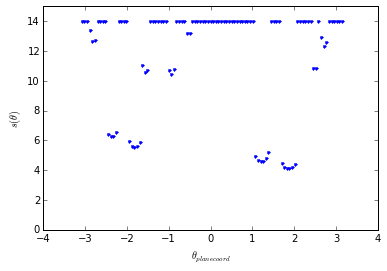

In [116]:
%pylab inline
%load_ext autoreload
%autoreload 2
import csv
o = open('laserdata.csv', 'rU')
mydata = csv.reader(o)

laseAngles2 = []
laserDepths = []
for row in mydata:
    laseAngles2.append(float(row[0]))
    laserDepths.append(float(row[1]))

laseAngles2 = np.array(laseAngles2)
laserDepths = np.array(laserDepths)
plt.plot(laseAngles2,laserDepths,'.')
plt.xlabel(r'$\theta_{plane coord}$')
plt.ylabel(r'$s(\theta)$')
plt.axis([-4, 4, 0, 15])
plt.show()

[-3.14159265 -2.0943951  -1.04719755  0.          1.04719755  2.0943951 ]


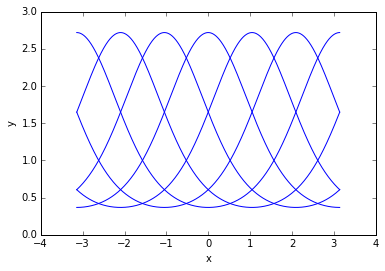

In [117]:
def vonMises(x, c_i, mu_i, kappa):
    return c_i *  np.exp(kappa*np.cos(x - mu_i))

def plotVonMises():
    x = np.linspace(-math.pi,math.pi,1000)
    N = 6 # number of means
    means = np.linspace(-math.pi,math.pi,N+1)
    means = means[:-1]
    print means
    #for i in means:
    #    plt.plot(x, vonMises(x, 0.14, i, 3), color='r')
    for i in means:
        plt.plot(x, vonMises(x, 1, i, 1), color='b')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
plotVonMises()


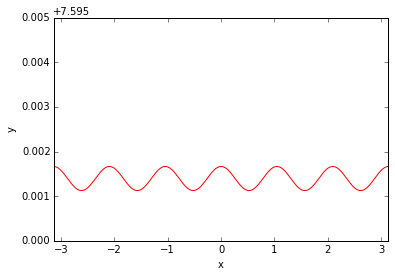

In [118]:
N_means = 6 # number of means
means = np.linspace(-math.pi,math.pi,N_means+1)
means = means[:-1]

def VMbasis(x, c_vec, mu_vec, kappa=1):
    if len(c_vec) != len(mu_vec):
        print "Need same size c_vec and mu_vec"
        return
    result = 0
    for i in range(len(c_vec)):
        result = result + vonMises(x, c_vec[i], mu_vec[i], kappa)
    return result

mu_vec = means
c_vec = means*0.0; c_vec[:] = 1.0
#c_vec[3] = -1.5
# for index, value in enumerate(c_vec):
#     c_vec[index] = index
# print c_vec


def plotVMbasis():
    x = np.linspace(-math.pi,math.pi,1000)
    y = x*0.0
    for index,value in enumerate(y):
        y[index] = VMbasis(x[index], c_vec, mu_vec)
    plt.plot(x, y, color='r')
    plt.axis([-3.14, 3.14, 7.595, 7.600])
    #plt.axis([-3.14, 3.14, 0, 10])
    plt.xlabel('x'); plt.ylabel('y'); plt.show()
    
plotVMbasis()


In [119]:
def VMbasisResidual(x, t, y):
    kappa=1
    c_vec = x[0:len(x)/2]
    mu_vec = x[len(x)/2:]
    if len(c_vec) != len(mu_vec):
        print "Need same size c_vec and mu_vec"
        return
    result = 0
    for i in range(len(c_vec)):
        result = result + vonMises(t, c_vec[i], mu_vec[i], kappa)
    return result - y

(100,)
(100,)


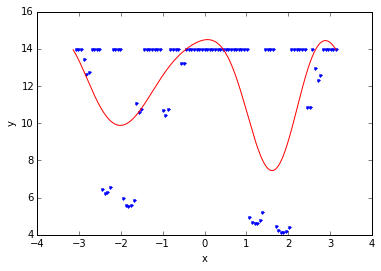

In [120]:
import scipy.optimize
from scipy.optimize import least_squares
t_train = np.array(laseAngles2)
y_train = np.array(laserDepths)

print np.shape(t_train)
print np.shape(y_train)

x0 = np.ones((12,1))[:,0]
res_lsq = least_squares(VMbasisResidual, x0, args=(t_train, y_train))

def plotVMbasisHere(x_vm, t, y):
    plt.plot(t,y,'.')
    x = np.linspace(-math.pi,math.pi,1000)
    y_hat = x*0.0
    c_vec = x_vm[0:len(x_vm)/2]
    mu_vec = x_vm[len(x_vm)/2:]
    for index,value in enumerate(y_hat):
        y_hat[index] = VMbasis(x[index], c_vec, mu_vec)
    plt.plot(x, y_hat, color='r')
    #plt.axis([-3.14, 3.14, 7.595, 7.600])
    #plt.axis([-3.14, 3.14, 0, 10])
    plt.xlabel('x'); plt.ylabel('y'); plt.show()
    
plotVMbasisHere(res_lsq.x, t_train, y_train)

In [121]:
x_vm = res_lsq.x
c_vec = x_vm[0:len(x_vm)/2]
mu_vec = x_vm[len(x_vm)/2:]

print mu_vec
tolerance = 0.001
step = 0.0001

def separateMeans():
    converged = False
    i = -1
    while(converged == False):
        i = i + 1
        print i
        if (mu_vec[i] - mu_vec[i+1])**2 < tolerance:
            print i, " and ", i+1, " are close"
            mu_vec[i] = mu_vec[i] - 0.1
            mu_vec[i+1] = mu_vec[i+1] + step
            i = -1
        if (i == len(mu_vec)-2):
            converged = True

separateMeans()            
print mu_vec

def vonMises(x, c_i, mu_i, kappa):
    return c_i *  np.exp(kappa*np.cos(x - mu_i))

def setUpFeatureMatrix(x_train, mu_vec):
    A = np.zeros((len(x_train),len(mu_vec)))
    for row_index,row in enumerate(A):
        for col_index, value in enumerate(row):
            A[row_index,col_index] = vonMises(x_train[row_index], 1, mu_vec[col_index], kappa=1)
    return np.matrix(A)
            
A_pete = setUpFeatureMatrix(laseAngles2, mu_vec)

[  5.45649349   5.46053685  -3.95478738   2.52424025 -11.47295329
   1.59078719]
0
0  and  1  are close
0
1
2
3
4
[  5.35649349   5.46063685  -3.95478738   2.52424025 -11.47295329
   1.59078719]


In [122]:
def setUpQP():
      
    #W = weighting matrix
    weights = laserDepths * 1.0
    for index, value in enumerate(weights):
        weights[index] = (1/value)**4
    W_pete = np.diag(weights)
    
    #b = vector of sensor measurements
    b_pete = laserDepths
    
    return np.matrix(W_pete), np.matrix(b_pete)
    
W_pete, b_pete = setUpQP()

print np.shape(A_pete)
print np.shape(A_pete.T)
print np.shape(A_pete * A_pete.T)
print np.shape(A_pete.T * A_pete)

(100, 6)
(6, 100)
(100, 100)
(6, 6)


In [123]:
import cvxopt

# P = A^T W A
P = cvxopt.matrix(A_pete.T * W_pete * A_pete)

# q^T = -b^T A
# q = -A^T b
q = cvxopt.matrix(- A_pete.T * W_pete *b_pete.T)

# G = A
G = cvxopt.matrix(A_pete)

# h = b_pete
h = cvxopt.matrix(b_pete.T)

A_zeros = np.copy(A_pete)
A_zeros[::] = 0

b_zeros = np.copy(b_pete)
b_zeros[:] = 0

A = cvxopt.matrix(A_zeros)
b = cvxopt.matrix(b_zeros.T)

# find the solution 
solution = cvxopt.solvers.qp(P, q, G, h)

alpha = np.array(solution['x'])

print alpha

c_constrained = alpha[:,0]

     pcost       dcost       gap    pres   dres
 0: -3.2037e-01  7.9559e+02  4e+03  5e-01  2e+03
 1: -5.0272e-01 -7.4695e+01  8e+01  1e-02  5e+01
 2: -4.9818e-01 -1.6188e+00  1e+00  1e-04  6e-01
 3: -5.6520e-01 -6.4574e-01  8e-02  2e-06  8e-03
 4: -5.9252e-01 -6.0537e-01  1e-02  2e-07  8e-04
 5: -5.9538e-01 -5.9988e-01  4e-03  4e-08  2e-04
 6: -5.9583e-01 -5.9700e-01  1e-03  2e-09  1e-05
 7: -5.9596e-01 -5.9605e-01  8e-05  2e-10  8e-07
 8: -5.9597e-01 -5.9597e-01  2e-06  3e-12  1e-08
 9: -5.9597e-01 -5.9597e-01  2e-08  3e-14  1e-10
Optimal solution found.
[[-23.73177689]
 [ 27.30119662]
 [-16.35358894]
 [ 17.00486436]
 [ -0.41812837]
 [  2.10666408]]


(6,)
(6,)
(12,)


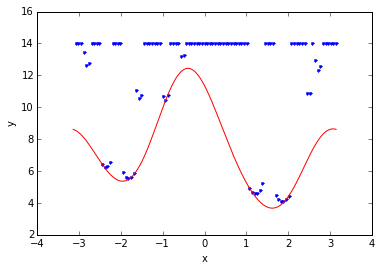

In [124]:
print np.shape(c_constrained)
print np.shape(mu_vec)
x_vm = np.hstack((c_constrained, mu_vec))
print np.shape(x_vm)

    
plotVMbasisHere(x_vm, t_train, y_train)